# Practical 4) The droplet growth equation: A moving size distribution

In the previous practical we solved the droplet growth equation for a mono-disperse aerosol population. Whilst this allowed us to profile some sensitivities, for a lot of aerosol simulations we need to consider a poly-disperse population. Here we will witness competitve growth under varying saturation ratios of codensates. This is important as a changing size distribution will have varying impacts and ensemble properties.

Rather than repeat the relevant equations here, in the figure below we repeat the schematics on how concentrations are represented in arrays and a schematic of a binned size distribution that, under positive saturation ratios, will grow and shift to the right hand side of the axes.

<table>
<tr>
<td> <img src="images/Droplet_growth_schematic2_multiplebins.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="images/Binned_size_distribution.png" alt="Drawing" style="width: 600px;"/> </td>
</tr>
</table>

<div class="alert alert-block alert-success">
<b>Objectives:</b> The objectives and exercises for today's practical are:

 - 1) [Objective 1 - Understand the structure of a program designed to solve the droplet growth equation for a poly-disperse population](#Part1)
      * [Exercise 1: Read through the provided code and understand links to theoretical framework](#Exercise1)
      * [Exercise 2: Calculate the final secondary mass from condensation](#Exercise2)
      * [Exercise 3: Change the properties of the condensed phase](#Exercise3)

</div>


<div class="alert alert-block alert-success">
<b> Exercise 1. Read through the provided code and understand links to theoretical framework <a name="Exercise1"> </b> 
    
As with the mono-disperse case, here we take time to understand the changes to our code that has enabled us to simulate a moving poly-disperse distribution. The parameters of our default simulation are as follows:

 - Mean diameter: 150nm
 - Smallest and largest diameters: 10nm and 1 micron respectively
 - Number of size bins: 8
 - Number of particles per cubic centimeter: 30
 - Mass accomodation coefficient of all condensates: 1.0
 - molecular weight of all condensates: 200 g.mol-1
 - Number of condensates: 10, with log10 C* values from -6 to 3 micrograms.m3
 
We also assume we start with an involatile core which has a molecular weight of 200 g.mol-1 and density of 1400 kg.m-3. Before you run anything, please read through the code provided to understand how the simulation is run. We are again using an internal ODE solver provided by the [Scipy]() Python package. This requires us to provide a function that defines both the droplet growth equations for each gas phase component and the subsequent loss from the gas phase. In this case, within the ODE function, we need to provide estimates of gain/loss for each condensate in every size bin. Just to illustrate this, you will notice the following structure within the function 'dy_dy':

```python
import numpy as np
from scipy.integrate import odeint 
# Define a differential equation to be solved
def dy_dt(<<inputs>>):
    ....
    # Now cycle through each size bin
    for size_step in range(num_bins):
        
    # Update change in gas phase concentrations
    
    # Update change in condensed phase concentrations
    
# Define an array of time steps [seconds]
t = np.linspace(<<start time>>, <<end time>>, num=<<number of points>>) # time span and steps (start, end, number of entries). Same as before, with 100 entries
solution = odeint(dy_dt, array, t, rtol=<<relative tolerance>>, atol=<<absolute tolerance>>)

```

Please note that introducing a for loop is not the most efficient approach and should be avoided where possible. Nonetheless this is used for illustrative purposes. When you run the code provided, you should see the following figures which plot the change in gas phase concentration for each volatility bin, the change in absolute and relative sizes.

![title <](images/Prac4_ex1.png)


</div>

41.5
total initial mass =  1.8583765342528633


No handles with labels found to put in legend.
No handles with labels found to put in legend.


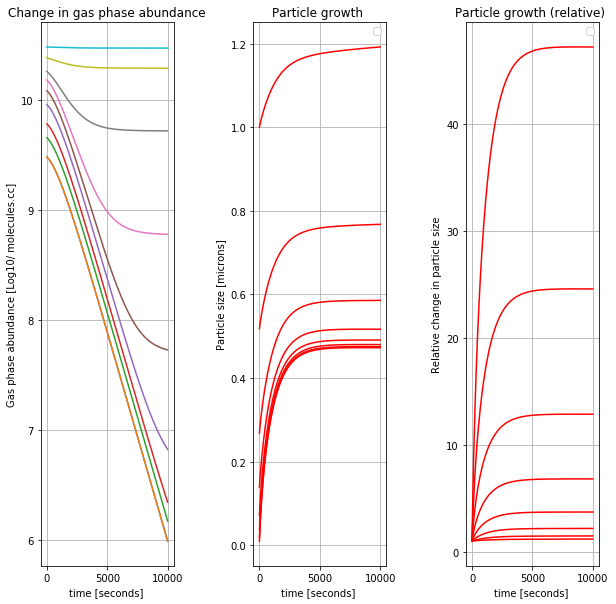

In [21]:
import numpy as np
from scipy.integrate import odeint # We only want to use the 'odeint' [Solve Initial Value Problems] from the scipy.integrate package
import matplotlib.pyplot as plt # Import Matplotlib so we can plot results

Temp_K = 298.15

# --- Physical constants ---
Lv_water_vapour=2.5e3 # Latent heat of vapourisation of water [J/g] 
Rv=461.0 #Individual gas constant of water vapour [J/Kg.K]
Ra=287.0 #Gas constant for dry air [J/Kg.K]
R_gas=8.3144598 #Ideal gas constant [kg m2 s-2 K-1 mol-1]
R_gas_other=8.2057e-5 #Ideal gas constant [m3 atm K-1 mol-1]
GRAV=9.8; #Gravitational acceleration [(m/2)2]
cp=1005; #Specific heat capacity of air [J/Kg.K]
sigma=72.0e-3 # Assume surface tension of water (mN/m)
NA=6.0221409e+23 #Avogadros number
kb=1.380648E-23 #Boltzmanns constant

# --- Properties of each gas in the volatility basis set ---
num_species = 10

# Molecular weight [g/mol]
mw_array=np.zeros((num_species), dtype=float)
mw_array[:]=200.0

log_c_star = np.linspace(-6, 3, num_species)
Cstar = np.power(10.0,log_c_star)
# Convert C* to saturation vapour pressure
P_sat = (Cstar*R_gas_other*Temp_K)/(1.0e6*mw_array)# atm
# Initialise an abundance of material in each volatility bin [micrograms/3]
abundance = np.zeros((num_species), dtype = float)
abundance[0] = 1.0
abundance[1] = 1.0
abundance[2] = 1.5
abundance[3] = 2.0
abundance[4] = 3.0
abundance[5] = 4.0
abundance[6] = 5.0
abundance[7] = 6.0
abundance[8] = 8.0
abundance[9] = 10.0
# Convert to molecules / cc 
gas_abundance = ((abundance*1.0e-6)/(mw_array))*1.0e-6*NA
print(np.sum(abundance))

# Accomodation coefficient [including water]
alpha_d_org=np.zeros((num_species), dtype=float)
alpha_d_org[:]=1.0 
# Density of condensing species
density_org=np.zeros((num_species), dtype=float)
density_org[:]=1400.0

# - Molecular diffusion coeffficient of each molecula in air. [cm2/s] - 
#We use an approximation to initialise this, but these values will also depend
#on the accomodation coefficient and size of particles condensing to. Following the
#approach in Topping et al (2013), diffusivity is calculated as 
DStar_org = 1.9*np.power(mw_array,-2.0/3.0)
# - Mean thermal velocity of each molecule [m/s] - 
mean_them_vel=np.power((8.0*R_gas*Temp_K)/(np.pi*(mw_array*1.0e-3)),0.5)
# - Mean free path for each molecule [m] - 
gamma_gas = ((3.0*DStar_org)/(mean_them_vel*1.0e2))*1.0e-2

# -------- Create a multi size bin distribution --------
# Volume ratio
d1 = 0.01 # Lowest size diameter
d_Nb = 1.0 # Diameter of largest bin [microns]
num_bins = 8 # Number of size bins

V_rat = np.power((d_Nb/d1),3.0/(num_bins-1.0)) # Volume ratio between bins
d_rat = V_rat**(1.0/3.0) # Diameter ratio between bins

# Use the volume ratio to create an array of diameters as follows
d_i=np.zeros((num_bins), dtype=float) # Diameter array 
d_i[0]=d1
for step in range(num_bins):
    if step > 0:
       d_i[step]=d_i[step-1]*d_rat
log_di = np.log(d_i) # Log of Diameter array 

# Parameters of log-normal distribution
sigmag1 = np.log(1.7) # Geometric standard deviation
mean1 = np.log(0.15) # Mean particle size [150nm]
distribution_1 = (np.exp(-(log_di - mean1)**2 / (2 * sigmag1**2)) / (sigmag1 * np.sqrt(2 * np.pi))) # Probability density distribution
d_width = d_i*np.power(2,1.0/3.0)*((np.power(V_rat,1.0/3.0)-1.0)/(np.power(1+V_rat,1.0/3.0))) # Diameter width array of size bins

N_total = 30.0 # Total number of particles [per cm-3]
N_dist = N_total*(distribution_1*(d_width/d_i)) # Discrete number distribution

density = 1400.0 #kg.m-3
total_mass = np.sum((4.0/3.0)*np.pi*np.power((d_i*1.0e-6),3.0)*N_dist*1.0e6*density*1.0e9)
print("total initial mass = ", total_mass)
# -------------------------------------------------------

# -------- Now initialise a core abundance using the above size distribution -------
core = np.zeros((num_bins), dtype=float)
core_abundance = np.zeros((num_bins), dtype=float)
density_core = np.zeros((num_bins), dtype=float)
core_mw = np.zeros((num_bins), dtype=float)

density_core[:] = 1400.0
core_mw[:] = 200.0

N_per_bin = N_dist

# Define size
size_array = d_i
# Use the size to now calculate a concentration of a 'core' in molecules / cc
core_abundance = (N_per_bin)*((4.0/3.0)*np.pi*np.power(size_array*1.0e-6,3.0)*density_core*1.0e3)
#print("core_abundance = ", core_abundance*1.0e6)
core_abundance = (core_abundance / core_mw)*NA
#print("core_abundance = ", core_abundance)
# New define an array that holds the molecular abundance of each gas and the concentration of 
# each gas in the size bin
array = np.zeros((num_species+num_species*num_bins), dtype=float)
array[0:num_species] = gas_abundance
array[num_species:num_species+num_species*num_bins] = 1.0e-10 # assuming we start with nothing 

def dy_dt(array,t):
    
    Cg_i_m_t = array[0:num_species] 
    
    # We are working with 8 size bins, each of which has an involatile core
    size_array = np.zeros((num_bins), dtype=float)
    
    dy_dt_array = np.zeros((num_species+num_species*num_bins), dtype=float)
    dy_dt_gas_matrix = np.zeros((num_species,num_bins), dtype=float)
    
    # Now cycle through each size bin
    for size_step in range(num_bins):
        
        # 1) Select a slice of y that represents this size bin \n')
        #temp_array = np.zeros((num_species+num_bins), dtype=float)
        temp_array=array[num_species+size_step*num_species:num_species+num_species*(size_step+1)]
        #print("temp_array = ",temp_array)
        #print("sum temp_array = ",np.sum(temp_array[:]))
        total_moles=np.sum(temp_array)+core_abundance[size_step]
        #print("total_moles = ",total_moles)
        mole_fractions=temp_array/total_moles 
        #print("mole_fractions = ",mole_fractions)
        # 2) Now mask the array to set the mole fracs of some species to 0 [inc oxidants]\n') 
        density_array = np.zeros((num_species+1), dtype=float)
        density_array[0:num_species]=density_org[0:num_species]
        density_array[num_species]=density_core[size_step]
        # Calculate total secondary organic mass 
        mass_array = np.zeros((num_species+1), dtype=float)
        mass_array[0:num_species] = (temp_array/NA)*mw_array
        mass_array[num_species] = (core_abundance[size_step]/NA)*core_mw[0]
        total_mass=np.sum(mass_array)
        #print("density_array = ",density_array)
        mass_fractions_array=mass_array/total_mass
        density=1.0/(np.sum(mass_fractions_array/density_array))
        #print("mass_fractions_array/density_array = ",mass_fractions_array/density_array)
        #3) In the below we need to remember that mass is in [g/cc] whilst density 
        # is in [kg/m3]. Thus we convert mass and number concentrations to kg/m3 and /m3 
        size_array[size_step]=((3.0*((total_mass*1.0e3)/(N_per_bin[size_step]*1.0e6)))/(4.0*np.pi*density))**(1.0/3.0) 
        #print("size_array = ",size_array)
        #4) Knudsen number  \n') 
        
        # Calculate the Knudsen number for all condensing molecules based on this new size \n') 
        # This relies on mean free path for each species [cm] and particle radius [cm]\n') 
        Kn=gamma_gas/size_array[size_step]
        #5) Non-continuum regime correction  \n') 
        # Calculate a correction factor according to the continuum versus non-continuum regimes\n') 
        # Expression taken from Jacobson et al (2000), page 457. They reference:\n') 
        # Fuchs and Sutugin 1971\n') 
        # Pruppacher and Klett 1997\n') 
        Inverse_Kn=1.0/Kn 
        Correction_part1=(1.33e0+0.71e0*Inverse_Kn)/(1.0e0+Inverse_Kn) 
        Correction_part2=(4.0e0*(1.0e0-alpha_d_org))/(3.0e0*alpha_d_org) 
        Correction_part3=1.0e0+(Correction_part1+Correction_part2)*Kn
        Correction=1.0/Correction_part3 
        # 6) Kelvin factor  \n') 
        # Now calculate a kelvin factor for every semi-volatile compound in this size bin\n') 
        kelvin_factor=np.exp((4.0E0*mw_array*1.0e-3*sigma)/(R_gas*Temp_K*size_array[size_step]*2.0e0*density)) 
        #print("kelvin = ",kelvin_factor)
        #7) Equilibrium pressure above droplets  \n') 
        #Now calculate an equilibrium RH for every compound in this size bin \n') 
        #This is currently in atmospheres.  \n') 
        Pressure_eq=kelvin_factor*mole_fractions*P_sat*101325.0e0 
        # 8) Calculate the equilibrium concentration equivalent \n') 
        # [Pa * molecules/mole * k mole  / Pa cm3 hence molecules/cm3] \n') 
        Cstar_i_m_t=Pressure_eq*(NA/(8.3144598e6*Temp_K))  
        #9) The droplet growth equation  \n') 
        # The following calculates the change in mass, per particle of this size. \n') 
        # The equation relies on the following parameters \n')  
        # and units. Always check units \n') 
        # radius [m] \n') 
        # DStar_org [m2/s] - pass in [cm2/s] so needs to be converted by *1.0E-4 \n') 
        # Pressure_gas [Pascals] \n') 
        # Pressure_eq [Pascals] \n') 
        # R_gas [m3 Pascals /(K mol)] \n') 
        # molw [g/mol] \n') 
        # T [K] \n') 
        # The units of the equation should therefore be g/s \n') 
        # ASTEM version - should be the same as the Jacobson version once coverted to molecules/cc/s \n') 
        k_i_m_t_part1 = DStar_org*Correction  
        k_i_m_t=4.0e0*np.pi*size_array[size_step]*1.0e2*N_per_bin[size_step]*k_i_m_t_part1    
        dm_dt=k_i_m_t*(Cg_i_m_t-Cstar_i_m_t) 
        #print("Cstar_i_m_t = ", Cstar_i_m_t)
        #print("dm_dt = ",dm_dt)  
        #print("k_i_m_t = ",k_i_m_t)  
        #10) Now update the contribution to the ODEs being solved  \n') 
        # a) Add contributory loss from the gas phase to particle phase [this includes water] \n') 
        
        dy_dt_gas_matrix[0:num_species,size_step]=dm_dt    
        # b) Add a contributory gain to the particle phase from the gas phase \n') 
        #index1=num_species+((size_step+1)*num_species) 
        #index2=num_species+((size_step)*num_species)  
        dy_dt_array[num_species+size_step*num_species:num_species+num_species*(size_step+1)]=dm_dt[0:num_species] 
        
        #pdb.set_trace()
    
    #print(size_array[4])
    dy_dt_array[0:num_species]=dy_dt_array[0:num_species]-np.sum(dy_dt_gas_matrix, axis=1)
                       
    return dy_dt_array

t = np.linspace(0, 10000, num=5000) # time span and steps (start, end, number of entries). Same as before, with 100 entries
solution = odeint(dy_dt, array, t, rtol=1.0e-6, atol=1.0e-20, tcrit=None)

# Now extract a size distribution for every point in the simulation
size_array_matrix = np.zeros((5000,num_bins), dtype=float)

# Let's now try to plot the size variation as a function of time
for step in range(solution.shape[0]):

    for size_step in range(num_bins):
        
        # 1) Select a slice of y that represents this size bin \n')
        #temp_array = np.zeros((num_species+num_bins), dtype=float)
        temp_array=solution[step,num_species+size_step*num_species:num_species+num_species*(size_step+1)]
        #print("temp_array = ",temp_array)
        #print("sum temp_array = ",np.sum(temp_array[:]))
        total_moles=np.sum(temp_array)+core_abundance[size_step]
        #print("total_moles = ",total_moles)
        mole_fractions=temp_array/total_moles 
        #print("mole_fractions = ",mole_fractions)
        # 2) Now mask the array to set the mole fracs of some species to 0 [inc oxidants]\n') 
        density_array = np.zeros((num_species+1), dtype=float)
        density_array[0:num_species]=density_org[0:num_species]
        density_array[num_species]=density_core[size_step]
        # Calculate total secondary organic mass 
        mass_array = np.zeros((num_species+1), dtype=float)
        mass_array[0:num_species] = (temp_array/NA)*mw_array
        mass_array[num_species] = (core_abundance[size_step]/NA)*core_mw[size_step]
        total_mass=np.sum(mass_array)
        #print("density_array = ",density_array)
        mass_fractions_array=mass_array/total_mass
        density=1.0/(np.sum(mass_fractions_array/density_array))
        #print("mass_fractions_array/density_array = ",mass_fractions_array/density_array)
        #3) In the below we need to remember that mass is in [g/cc] whilst density 
        # is in [kg/m3]. Thus we convert mass and number concentrations to kg/m3 and /m3 
        size_array_matrix[step,size_step]=((3.0*((total_mass*1.0e3)/(N_per_bin[size_step]*1.0e6)))/(4.0*np.pi*density))**(1.0/3.0) 
    
# Plot the decrease in gas phase abundance with the growth of the particle [both absolute and relative]

fig = plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.plot(t, np.log10(solution[:,0:num_species]))
plt.grid()
plt.xlabel('time [seconds] ')
plt.ylabel('Gas phase abundance [Log10/ molecules.cc]')
plt.title('Change in gas phase abundance')
plt.subplot(1, 3, 2)
plt.plot(t, size_array_matrix*1.0e6, 'r-')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time [seconds] ')
plt.ylabel('Particle size [microns]')
plt.title('Particle growth ')
plt.subplot(1, 3, 3)
plt.plot(t, size_array_matrix/size_array_matrix[0,:], 'r-')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time [seconds] ')
plt.ylabel('Relative change in particle size')
plt.title('Particle growth (relative) ')
plt.subplots_adjust(hspace=0.4, wspace=0.6)
plt.show()

<div class="alert alert-block alert-success">
<b> Exercise 2. Calculate the final secondary mass from condensation <a name="Exercise2"> </b> 
    
Following the simulation, you are now asked to calculate the final secondary mass from condensational growth. You should only need to add one line, and your result should be: 

</div>

In [20]:
#------'INSERT CODE HERE'------
total_mass_final = np.sum((4.0/3.0)*np.pi*np.power((size_array_matrix[4999,:]),3.0)*N_dist*1.0e6*density*1.0e9)
#------------------------------
print("final total mass = ", total_mass_final)

final total mass =  25.244088695869976
